# Bootstrap for OLS — Train/Test MSE vs Degree

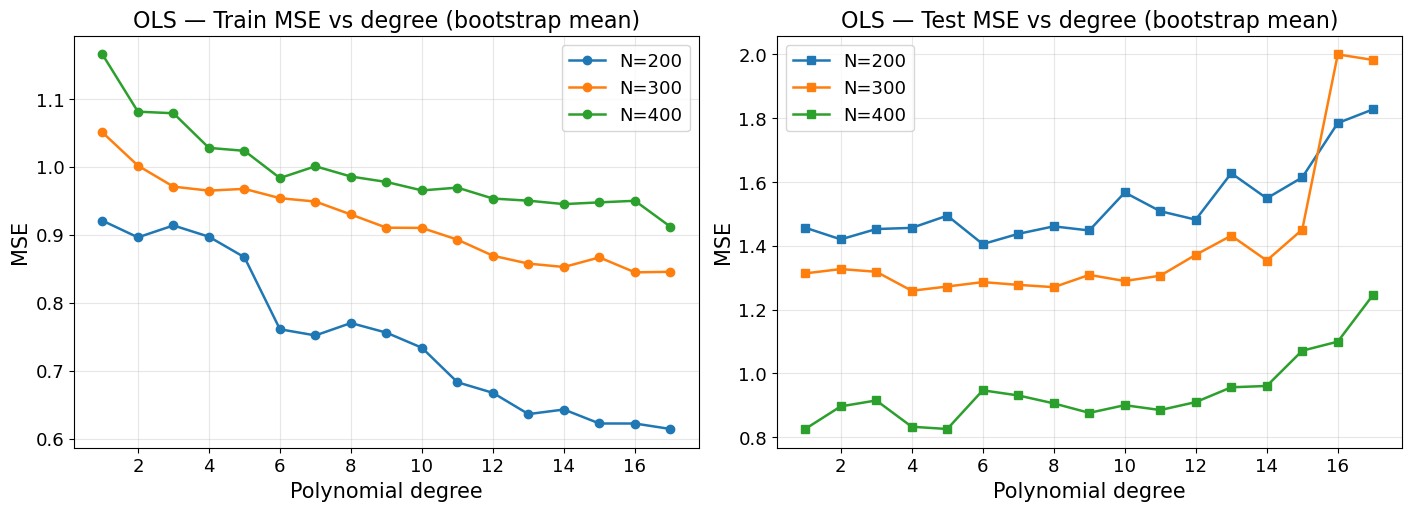

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from mlmods.metrics_utils import mse
from mlmods.data_utils import runge, prepare_design_from_indices  

# Reproducibility and bootstrap setup
SEED = 3155
np.random.seed(SEED)
B = 120  # number of bootstrap resamples per degree

Ns =  [200, 300, 400]
degree_range = range(1, 18)

# Font sizes 
fontsize_title = 16
fontsize_label = 15
fontsize_legend = 13

# Storage for mean curves
curves_train_mean, curves_test_mean = {}, {}

for N in Ns: 
    x = np.linspace(-1, 1, N)
    y_true = runge(x)
    y = y_true + np.random.normal(0, 1, size=N)

    # fixed train/test split
    idx = np.arange(N)
    tr_idx, te_idx = train_test_split(idx, test_size=0.2, shuffle=True, random_state=SEED)

    deg_train_means, deg_test_means = [], []

    for d in degree_range:
        boot_train_mse, boot_test_mse = [], []

        for b in range(B):
            # Bootstrap resample training indices with replacement
            boot_tr = np.random.choice(tr_idx, size=len(tr_idx), replace=True)

            # Build design matrices (centering on bootstrap training subset)
            X_tr, X_te, y_tr, y_te = prepare_design_from_indices(
                x, y, d, boot_tr, te_idx, mode="center"
            )

            # Closed-form OLS on bootstrap training set
            theta_b = np.linalg.pinv(X_tr) @ y_tr

            # Record MSEs
            boot_train_mse.append(mse(y_tr, X_tr @ theta_b))
            boot_test_mse.append(mse(y_te, X_te @ theta_b))

        # Mean across bootstrap replicates
        deg_train_means.append(float(np.mean(boot_train_mse)))
        deg_test_means.append(float(np.mean(boot_test_mse)))

    # Store mean MSE curves
    curves_train_mean[N] = np.array(deg_train_means)
    curves_test_mean[N]  = np.array(deg_test_means)

# Plot: two columns (Train / Test), multiple lines (one per N)
deg_list = np.array(list(degree_range))
fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

# Column 1: Train MSE
ax = axes[0]
for N in Ns:
    ax.plot(deg_list, curves_train_mean[N], marker='o', linewidth=1.8, label=f"N={N}")
ax.set_title("OLS — Train MSE vs degree (bootstrap mean)", fontsize=fontsize_title)
ax.set_xlabel("Polynomial degree", fontsize=fontsize_label)
ax.set_ylabel("MSE", fontsize=fontsize_label)
ax.tick_params(axis="both", labelsize=fontsize_label - 2)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=fontsize_legend)

# Column 2: Test MSE 
ax = axes[1]
for N in Ns:
    ax.plot(deg_list, curves_test_mean[N], marker='s', linewidth=1.8, label=f"N={N}")
ax.set_title("OLS — Test MSE vs degree (bootstrap mean)", fontsize=fontsize_title)
ax.set_xlabel("Polynomial degree", fontsize=fontsize_label)
ax.set_ylabel("MSE", fontsize=fontsize_label)
ax.tick_params(axis="both", labelsize=fontsize_label - 2)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=fontsize_legend)

plt.savefig("Bootstrap_true.pdf", dpi=300)
plt.show()